# **Projet Walmart**

# Partie 0 : import des librairies et du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [2]:
dataset = pd.read_csv("Walmart_Store_sales.csv")
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [3]:
dataset.shape

(150, 8)

# Partie 1 : EDA et Preprocessing

In [4]:
print("Nombre de lignes :")
print(dataset.shape[0])
print()
print("Stats de base :")
display(dataset.describe(include="all"))
print()
print("Percentage of missing values :")
display(100*dataset.isnull().sum()/dataset.shape[0])

Nombre de lignes :
150

Stats de base :


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values :


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

## Suppression de lignes

### Variable Weekly_Sales

La variable Weekly_Sales est notre variable cible y. \
Il nous manque des valeurs pour cette variable : on va supprimer toutes les lignes dont les valeurs pour la variable Weekly_Sales sont absentes.

In [5]:
dataset["Weekly_Sales"].value_counts(dropna=False)

Weekly_Sales
NaN           14
1572117.54     1
1799520.14     1
1494251.50     1
860336.16      1
              ..
1661767.33     1
526525.16      1
961186.23      1
311906.70      1
1255087.26     1
Name: count, Length: 137, dtype: int64

Il y a donc 14 lignes à supprimer.

In [6]:
dataset_clean = dataset.copy()

In [7]:
dataset_clean = dataset[~dataset["Weekly_Sales"].isna()].reset_index(drop=True) # ~ -> mask complémentaire du mask indiqué
dataset_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
3,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
4,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...
131,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
132,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
133,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
134,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


### Variables Temperature, Fuel_Price, CPI et Unemployment

Pour chacune de ces variables, on va enlever toutes les lignes dont les valeurs ne sont pas dans l'intervalle [mean - 3* sigma, mean + 3* sigma].

In [8]:
Temperature_mean = dataset_clean["Temperature"].mean()
Temperature_std = dataset_clean["Temperature"].std()

Temperature_index = dataset_clean["Temperature"][(dataset_clean["Temperature"] < Temperature_mean - 3*Temperature_std) | (dataset_clean["Temperature"] > Temperature_mean + 3*Temperature_std)].index
Temperature_index

Index([], dtype='int64')

Il n'y a aucune valeur aberrante pour Temperature.

In [9]:
Fuel_Price_mean = dataset_clean["Fuel_Price"].mean()
Fuel_Price_std = dataset_clean["Fuel_Price"].std()

Fuel_Price_index = dataset_clean["Fuel_Price"][(dataset_clean["Fuel_Price"] < Fuel_Price_mean - 3*Fuel_Price_std) | (dataset_clean["Fuel_Price"] > Fuel_Price_mean + 3*Fuel_Price_std)].index
Fuel_Price_index

Index([], dtype='int64')

Il n'y a aucune valeur aberrante pour Fuel_Price.

In [10]:
CPI_mean = dataset_clean["CPI"].mean()
CPI_std = dataset_clean["CPI"].std()

CPI_index = dataset_clean["CPI"][(dataset_clean["CPI"] < CPI_mean - 3*CPI_std) | (dataset_clean["CPI"] > CPI_mean + 3*CPI_std)].index
CPI_index

Index([], dtype='int64')

Il n'y a pas de valeur aberrante pour CPI.

In [11]:
Unemployment_mean = dataset_clean["Unemployment"].mean()
Unemployment_std = dataset_clean["Unemployment"].std()

Unemployment_index = dataset_clean["Unemployment"][(dataset_clean["Unemployment"] < Unemployment_mean - 3*Unemployment_std) | (dataset_clean["Unemployment"] > Unemployment_mean + 3*Unemployment_std)].index
Unemployment_index

Index([28, 58, 64, 85, 122], dtype='int64')

Il y a 5 valeurs aberrantes pour Unemployment.

On retire toutes les lignes où il y a des valeurs aberrantes.

In [12]:
dataset_clean = dataset_clean.drop(Unemployment_index).reset_index(drop=True)
dataset_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
3,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
4,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...
126,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
127,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
128,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
129,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


On va également supprimer tous les Nan de ces colonnes, car ce sont des valeurs qui sont difficiles à imputer de manière logique.

In [13]:
dataset_clean = dataset_clean[~dataset_clean["Temperature"].isna()].reset_index(drop=True) # ~ -> mask complémentaire du mask indiqué
dataset_clean = dataset_clean[~dataset_clean["Fuel_Price"].isna()].reset_index(drop=True)
dataset_clean = dataset_clean[~dataset_clean["CPI"].isna()].reset_index(drop=True)
dataset_clean = dataset_clean[~dataset_clean["Unemployment"].isna()].reset_index(drop=True)
dataset_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
3,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
4,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
...,...,...,...,...,...,...,...,...
85,7.0,25-05-2012,532739.77,0.0,50.60,3.804,197.588605,8.090
86,3.0,04-06-2010,396968.80,0.0,78.53,2.705,214.495838,7.343
87,3.0,19-10-2012,424513.08,0.0,73.44,3.594,226.968844,6.034
88,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899


### Variable Date

In [14]:
dataset_clean["Date"].value_counts(dropna=False)

Date
NaN           10
18-06-2010     3
25-03-2011     3
16-03-2012     3
20-04-2012     2
              ..
05-08-2011     1
30-03-2012     1
01-06-2012     1
06-07-2012     1
04-06-2010     1
Name: count, Length: 63, dtype: int64

18 lignes n'ont pas de dates indiquées. Regardons ce que cela donne pour le premier magasin.

In [15]:
dataset_clean[dataset_clean["Store"] == 1.0]["Date"].value_counts(dropna=False)

Date
16-03-2012    1
12-02-2010    1
05-08-2011    1
27-08-2010    1
18-11-2011    1
14-05-2010    1
Name: count, dtype: int64

Il est très compliqué de remplir les valeurs manquantes de manière cohérente... \
Nous allons supprimer toutes les lignes dont la date est absente.

In [16]:
dataset_clean = dataset_clean[~dataset_clean["Date"].isna()].reset_index(drop=True) # ~ -> mask complémentaire du mask indiqué
dataset_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
3,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
4,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
...,...,...,...,...,...,...,...,...
75,7.0,25-05-2012,532739.77,0.0,50.60,3.804,197.588605,8.090
76,3.0,04-06-2010,396968.80,0.0,78.53,2.705,214.495838,7.343
77,3.0,19-10-2012,424513.08,0.0,73.44,3.594,226.968844,6.034
78,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899


### Variable Holiday_Flag

In [17]:
dataset_clean["Holiday_Flag"].value_counts(dropna=False)

Holiday_Flag
0.0    65
NaN     9
1.0     6
Name: count, dtype: int64

On va remplacer tous les NaN par 0.0.

In [18]:
dataset_clean["Holiday_Flag"][dataset_clean["Holiday_Flag"].isna()] = 0.0
dataset_clean["Holiday_Flag"].value_counts(dropna=False)

C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_7856\4129341143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean["Holiday_Flag"][dataset_clean["Holiday_Flag"].isna()] = 0.0


Holiday_Flag
0.0    74
1.0     6
Name: count, dtype: int64

## EDA et analyse des données

### Varible Weekly_Sales

<Axes: xlabel='Weekly_Sales', ylabel='Density'>

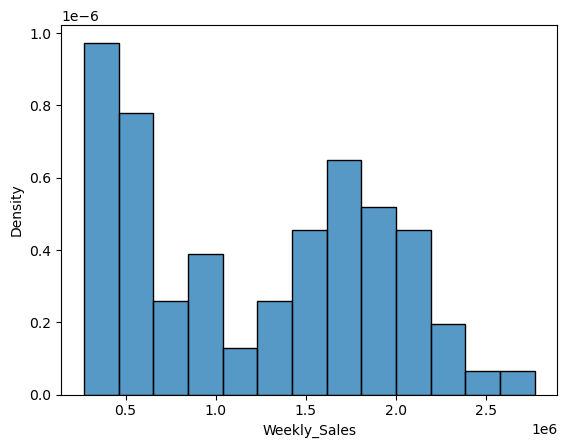

In [19]:
sns.histplot(dataset_clean, x="Weekly_Sales", stat="density", bins=13)

In [20]:
print("Plus petite vente hebdo :", dataset_clean["Weekly_Sales"].min())
print("Plus grande vente hebdo :", dataset_clean["Weekly_Sales"].max())

Plus petite vente hebdo : 268929.03
Plus grande vente hebdo : 2771397.17


### Variable Store

In [21]:
dataset_clean["Store"].value_counts().sort_index()

Store
1.0     6
2.0     3
3.0     8
4.0     5
5.0     5
6.0     4
7.0     7
8.0     4
9.0     3
10.0    2
11.0    1
13.0    7
14.0    4
15.0    2
16.0    3
17.0    3
18.0    4
19.0    6
20.0    3
Name: count, dtype: int64

On voit qu'il n'y a aucune valeur manquante pour cette variable.

On peut voir que nous avons des données sur 20 magasins différents.

In [22]:
dataset_clean["Store"].value_counts().index

Index([ 3.0, 13.0,  7.0, 19.0,  1.0,  5.0,  4.0, 14.0,  6.0, 18.0,  8.0, 17.0,
       16.0, 20.0,  2.0,  9.0, 15.0, 10.0, 11.0],
      dtype='float64', name='Store')

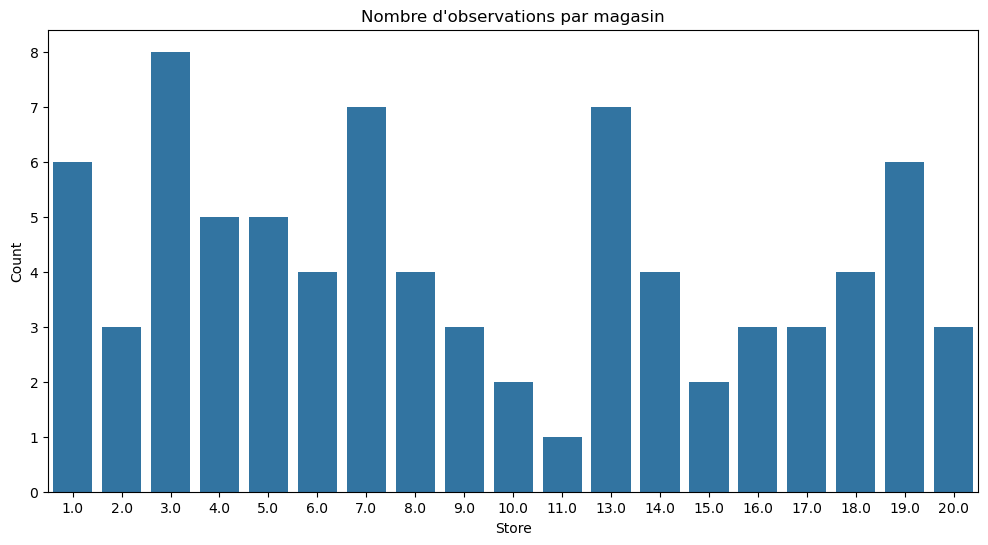

In [23]:
plt.figure(figsize=(12,6))
sns.barplot(x=dataset_clean["Store"].value_counts().index, y=dataset_clean["Store"].value_counts().values)
plt.ylabel("Count")
plt.title("Nombre d'observations par magasin")
plt.show()

On remarque que le nombre d'observations par magasin varie (8 pour le maximumn, 1 pour le minimum).

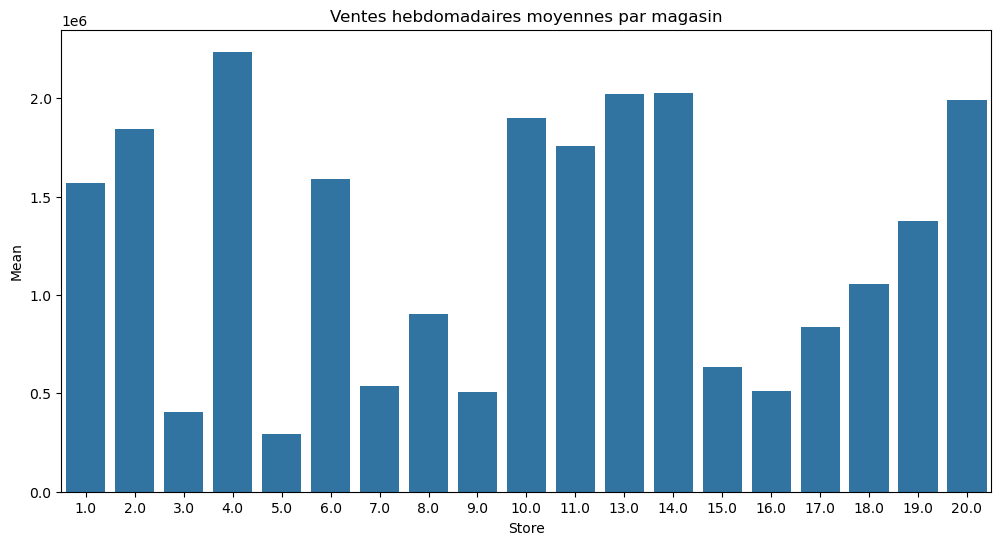

In [24]:
mean_sales_store = dataset_clean.groupby("Store")["Weekly_Sales"].mean()
plt.figure(figsize=(12,6))
sns.barplot(x=mean_sales_store.index, y=mean_sales_store.values)
plt.ylabel("Mean")
plt.title("Ventes hebdomadaires moyennes par magasin")
plt.show()

On peut voir que certains magasins font plus de chiffres d'affaires que d'autres :
- le magasin 3 et 5 font les moins bons chiffres d'affaires
- les magasins 4, 13, 14 et 20 les meilleurs chiffres d'affaires

### Variable Date

On va créer 4 nouvelles colonnes :
- year
- month
- day
- dayofweek

In [25]:
type(dataset_clean["Date"][0])

str

In [26]:
dataset_clean["Format_Date"] = pd.to_datetime(dataset_clean["Date"], format="%d-%m-%Y")

dataset_clean["year"] = dataset_clean["Format_Date"].dt.year
dataset_clean["month"] = dataset_clean["Format_Date"].dt.month
dataset_clean["day"] = dataset_clean["Format_Date"].dt.day
dataset_clean["dayofweek"] = dataset_clean["Format_Date"].dt.dayofweek

dataset_clean.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Format_Date,year,month,day,dayofweek
0,6.0,18-02-2011,1572117.54,0.0,59.61,3.045,214.777523,6.858,2011-02-18,2011,2,18,4
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011-03-25,2011,3,25,4
2,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010-05-28,2010,5,28,4
3,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658,2011-06-03,2011,6,3,4
4,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012-02-03,2012,2,3,4


On supprime les colonnes Date et Format_Date, nous n'en avons plus besoin.

In [27]:
dataset_clean = dataset_clean.drop(["Date", "Format_Date"], axis=1)
dataset_clean.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofweek
0,6.0,1572117.54,0.0,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
2,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
3,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4
4,20.0,2203523.20,0.0,39.93,3.617,213.023622,6.961,2012,2,3,4


#### Variable year

In [28]:
dataset_clean["year"].value_counts(dropna=False)

year
2010    32
2011    25
2012    23
Name: count, dtype: int64

On peut voir que le dataset comprend des observations comprises entre 2010 et 2012.

#### Variable month

In [29]:
dataset_clean["month"].value_counts(dropna=False).sort_index()

month
1      1
2      8
3      9
4      7
5      8
6      9
7     11
8      7
9      4
10     6
11     6
12     4
Name: count, dtype: int64

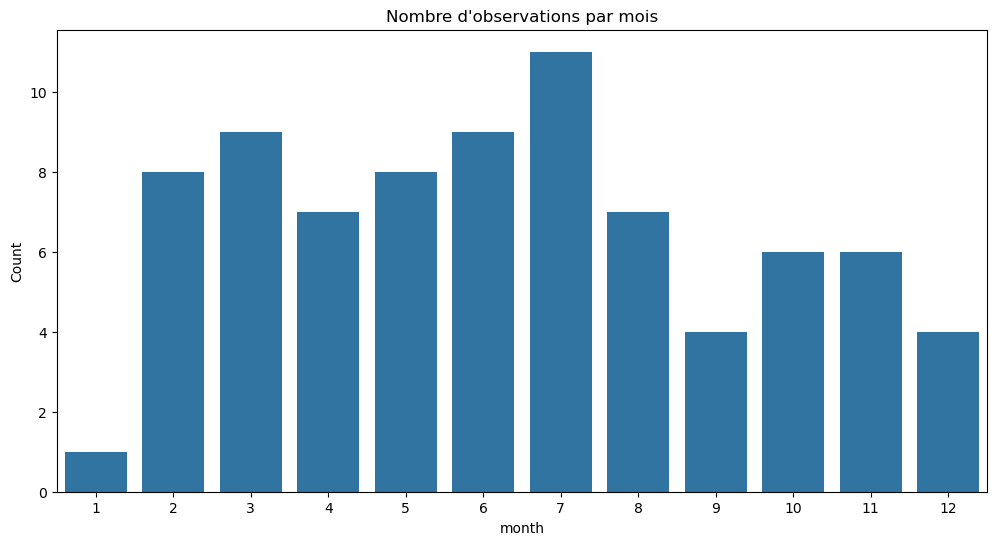

In [30]:
plt.figure(figsize=(12,6))
sns.barplot(x=dataset_clean["month"].value_counts().index, y=dataset_clean["month"].value_counts().values)
plt.ylabel("Count")
plt.title("Nombre d'observations par mois")
plt.show()

#### Variable day

In [31]:
dataset_clean["day"].value_counts(dropna=False).sort_index()

day
1     2
2     4
3     2
4     2
5     2
6     2
7     2
8     1
9     2
10    3
11    2
12    6
13    2
14    1
15    2
16    5
17    2
18    6
19    4
20    3
22    3
23    2
24    2
25    5
26    3
27    3
28    1
29    1
30    4
31    1
Name: count, dtype: int64

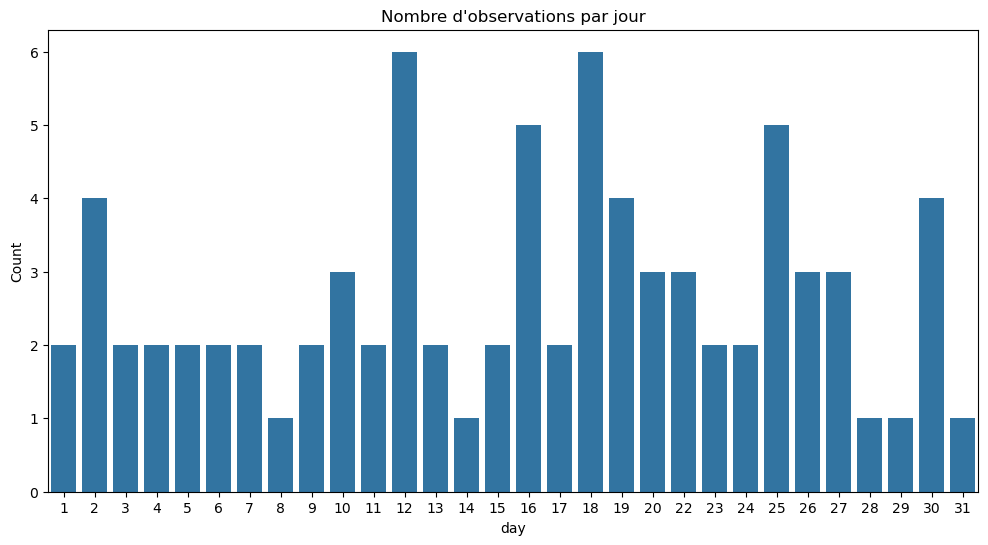

In [32]:
plt.figure(figsize=(12,6))
sns.barplot(x=dataset_clean["day"].value_counts().index, y=dataset_clean["day"].value_counts().values)
plt.ylabel("Count")
plt.title("Nombre d'observations par jour")
plt.show()

Pas de commentaire.

#### Variable dayofweek

In [33]:
dataset_clean["dayofweek"].value_counts(dropna=False)

dayofweek
4    80
Name: count, dtype: int64

On remarque que toutes le calcul des ventes de la semaine ont lieu le vendredi. \
Pour l'entrainement du modèle, on ne prendra pas en compte cette colonne.

### Variable Holiday_Flag

In [34]:
dataset_clean["Holiday_Flag"].value_counts(dropna=False)

Holiday_Flag
0.0    74
1.0     6
Name: count, dtype: int64

In [35]:
dataset_holiday_flag = dataset_clean.copy()
dataset_holiday_flag["Holiday_Flag"][dataset_clean["Holiday_Flag"]==0.0] = "Hors vacances"
dataset_holiday_flag["Holiday_Flag"][dataset_clean["Holiday_Flag"]==1.0] = "Pendant les vacances"

dataset_holiday_flag["Holiday_Flag"].value_counts(dropna=False)

C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_7856\639188168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_holiday_flag["Holiday_Flag"][dataset_clean["Holiday_Flag"]==0.0] = "Hors vacances"
C:\Users\Théo REMY\AppData\Local\Temp\ipykernel_7856\639188168.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Hors vacances' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset_holiday_flag["Holiday_Flag"][dataset_clean["Holiday_Flag"]==0.0] = "Hors vacances"


Holiday_Flag
Hors vacances           74
Pendant les vacances     6
Name: count, dtype: int64

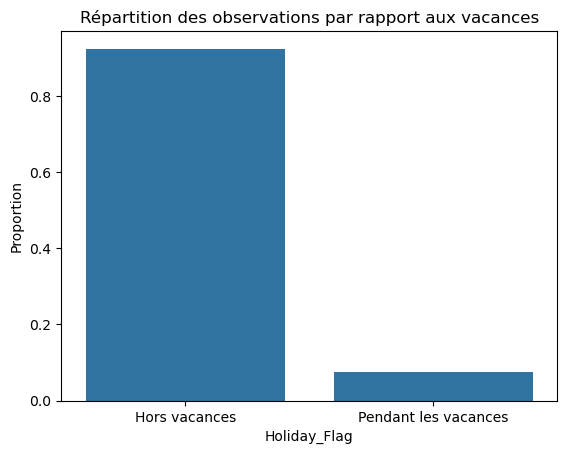

In [36]:
sns.countplot(data=dataset_holiday_flag, x="Holiday_Flag", stat="proportion")
plt.ylabel("Proportion")
plt.title("Répartition des observations par rapport aux vacances")
plt.show()

La plupart des observations ont eu lieu hors vacances.

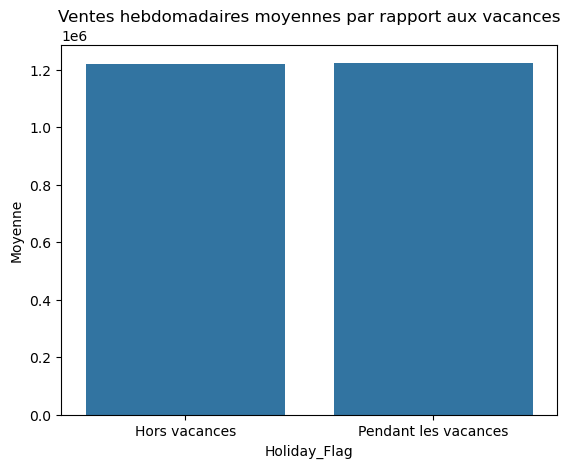

In [37]:
mean_sales_holiday_flag = dataset_holiday_flag.groupby("Holiday_Flag")[["Weekly_Sales"]].mean()
sns.barplot(data=mean_sales_holiday_flag, x="Holiday_Flag", y="Weekly_Sales")
plt.ylabel("Moyenne")
plt.title("Ventes hebdomadaires moyennes par rapport aux vacances")
plt.show()

On ne voit pas de réelles différences dans les ventes en fonction de si l'on est en vacances ou non.

### Variable Temperature

<Axes: xlabel='Temperature', ylabel='Density'>

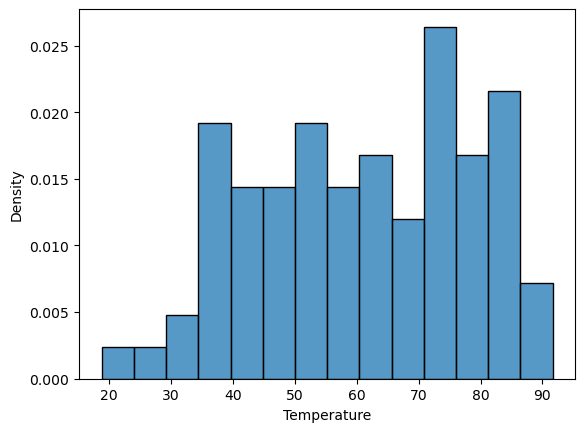

In [38]:
sns.histplot(data=dataset_clean, x="Temperature", stat="density", bins=14)

Les températures sont en Farhenheit... On va transformer la température en Celsius.

In [39]:
dataset_clean["Temperature"] = dataset_clean["Temperature"].apply(lambda x : (x-32)*5/9)

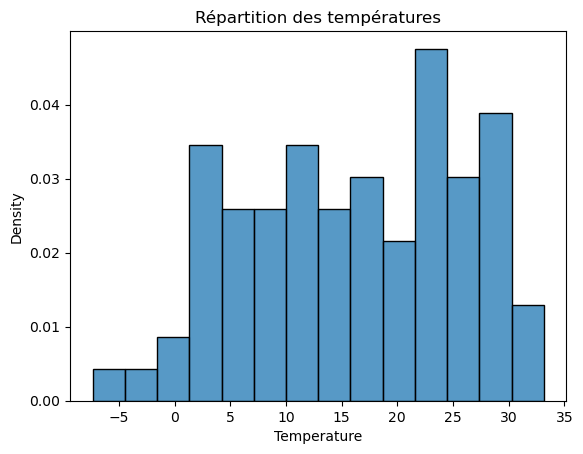

In [40]:
sns.histplot(data=dataset_clean, x="Temperature", stat="density", bins=14)
plt.title("Répartition des températures")
plt.show()

In [41]:
print("Temperature min :", dataset_clean["Temperature"].min())
print("Temperature max :", dataset_clean["Temperature"].max())

Temperature min : -7.33888888888889
Temperature max : 33.138888888888886


Les températures au moment des observations varient environ entre -7 °C et 33 °C.

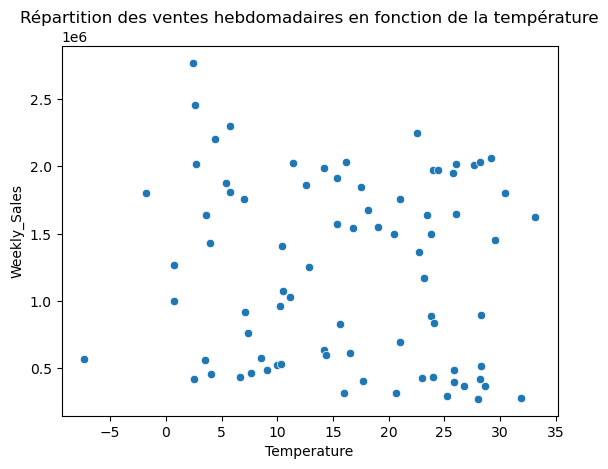

In [42]:
sns.scatterplot(data=dataset_clean, x="Temperature", y="Weekly_Sales")
plt.title("Répartition des ventes hebdomadaires en fonction de la température")
plt.show()

Il ne semble pas y avoir de corrélation évidente entre la temperature et les ventes hebdomadaires.

### Fuel_Price

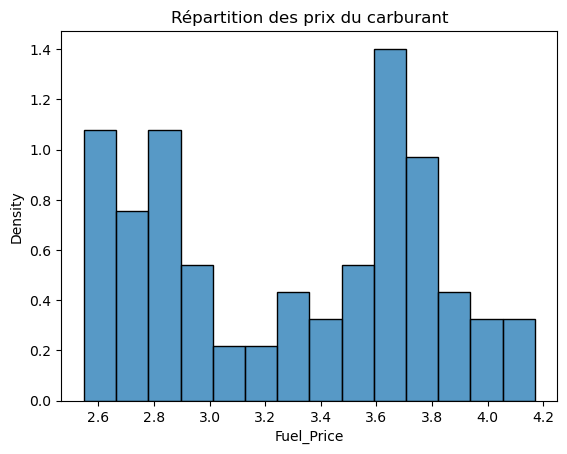

In [43]:
sns.histplot(data=dataset_clean, x="Fuel_Price", stat="density", bins=14)
plt.title("Répartition des prix du carburant")
plt.show()

In [44]:
print("Fuel_Price min :", dataset_clean["Fuel_Price"].min())
print("Fuel_Price max :", dataset_clean["Fuel_Price"].max())

Fuel_Price min : 2.548
Fuel_Price max : 4.17


Le prix du carburant varie entre 2.548 et 4.17 dollars.

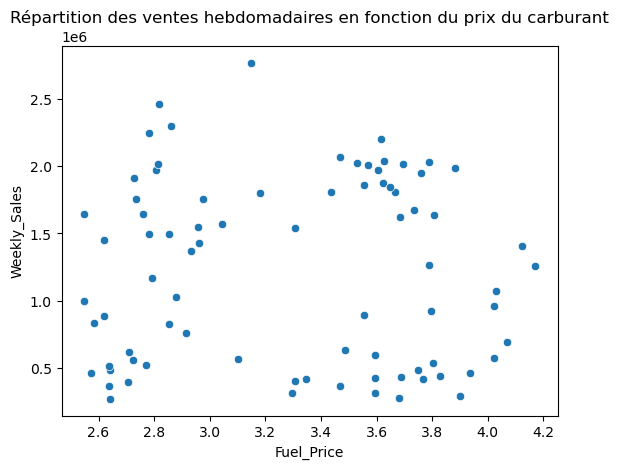

In [45]:
sns.scatterplot(data=dataset_clean, x="Fuel_Price", y="Weekly_Sales")
plt.title("Répartition des ventes hebdomadaires en fonction du prix du carburant")
plt.show()

Il ne semble pas y avoir de corrélation évidente entre le prix du carburant et les ventes hebdomadaires.

### Variable CPI

Le CPI (Cost Per Impression) représente le coût de diffusion d'une annonce publicitaire sur les réseaux sociaux, moteurs de recherche, site web, etc...

In [46]:
dataset_clean[dataset_clean["Store"]==1.0]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofweek
8,1.0,1677472.78,0.0,18.188889,3.734,221.211813,7.348,2012,3,16,4
26,1.0,1641957.44,1.0,3.616667,2.548,211.242170,8.106,2010,2,12,4
30,1.0,1624383.75,0.0,33.138889,3.684,215.544618,7.962,2011,8,5,4
45,1.0,1449142.92,0.0,29.566667,2.619,211.567306,7.787,2010,8,27,4
48,1.0,1539483.70,0.0,16.805556,3.308,218.220509,7.866,2011,11,18,4
54,1.0,1494251.50,0.0,23.766667,2.854,210.337426,7.808,2010,5,14,4


Le CPI n'est pas unique pour chaque magasin.

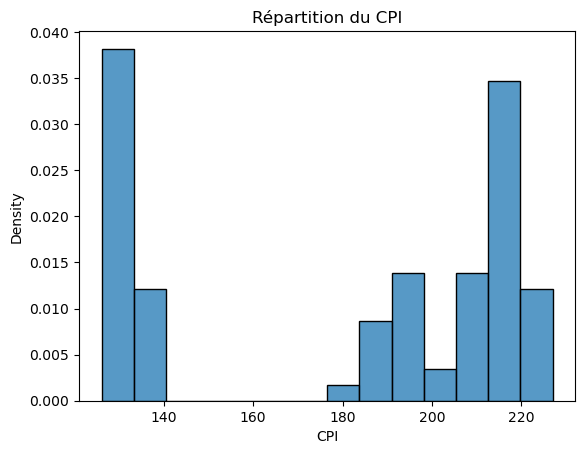

In [47]:
sns.histplot(data=dataset_clean, x="CPI", stat="density", bins=14)
plt.title("Répartition du CPI")
plt.show()

On remarque deux groupes de répartitions pour le CPI. Regardons cela un peu plus en détail.

In [48]:
dataset_clean_grp1 = dataset_clean[dataset_clean["CPI"] < 160]
dataset_clean_grp2 = dataset_clean[dataset_clean["CPI"] >= 160]

In [49]:
print("CPI min groupe 1 :", dataset_clean_grp1["CPI"].min(), ", CPI max groupe 1 :", dataset_clean_grp1["CPI"].max())
print("CPI min groupe 2 :", dataset_clean_grp2["CPI"].min(), ", CPI max groupe 2 :", dataset_clean_grp2["CPI"].max())

CPI min groupe 1 : 126.1392 , CPI max groupe 1 : 138.9117
CPI min groupe 2 : 182.4424199 , CPI max groupe 2 : 226.9688442


Vérifions qu'il n'y a pas de magasin en commun entre dataset_clean_grp1 et dataset_clean_grp2

In [50]:
dataset_clean_grp1_store = dataset_clean_grp1["Store"].value_counts().sort_index()
dataset_clean_grp1_store

Store
4.0     5
10.0    2
13.0    7
15.0    2
17.0    3
18.0    4
19.0    6
Name: count, dtype: int64

In [51]:
dataset_clean_grp2_store = dataset_clean_grp2["Store"].value_counts().sort_index()
dataset_clean_grp2_store

Store
1.0     6
2.0     3
3.0     8
5.0     5
6.0     4
7.0     7
8.0     4
9.0     3
11.0    1
14.0    4
16.0    3
20.0    3
Name: count, dtype: int64

In [52]:
# On regarde les index communs
index_communs = dataset_clean_grp1_store.index.intersection(dataset_clean_grp2_store.index)
index_communs

Index([], dtype='float64', name='Store')

Ainsi nous avons deux groupes de magasins : 
- un premier groupe, avec les magasins 4.0, 10.0, 13.0, 15.0, 17.0, 18.0 et 19.0, avec un CPI compris entre 126 et 139 dollars.
- un deuxième groupe, avec les autres magasins, avec un CPI compris entre 182 et 227 dollars.

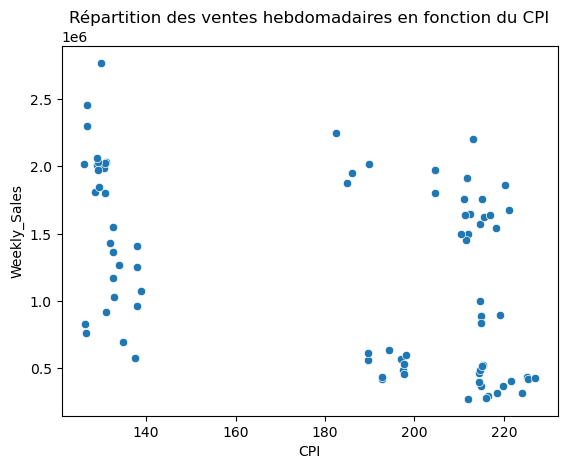

In [53]:
sns.scatterplot(data=dataset_clean, x="CPI", y="Weekly_Sales")
plt.title("Répartition des ventes hebdomadaires en fonction du CPI")
plt.show()

Il ne semble pas y avoir de corrélation évidente entre le CPI et les ventes hebdomadaires. \
On remarque également qu'au sein d'un groupe, les ventes hebdomadaires varient.

### Variable Unemployment

La colonne Unemployment représente le taux de chômage (en pourcentage) dans la région où se situe le magasin.

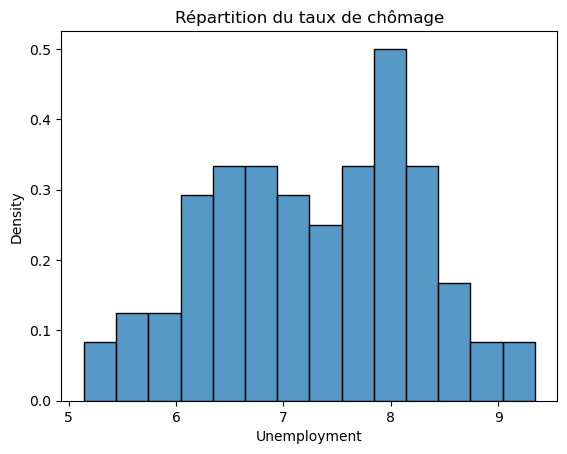

In [54]:
sns.histplot(data=dataset_clean, x="Unemployment", stat="density", bins=14)
plt.title("Répartition du taux de chômage")
plt.show()

In [55]:
print("Taux de chômage min :", dataset_clean["Unemployment"].min())
print("Taux de chômage max :", dataset_clean["Unemployment"].max())

Taux de chômage min : 5.143
Taux de chômage max : 9.342


Le taux de chômage se situe entre 5,143 % et 9,342 %.

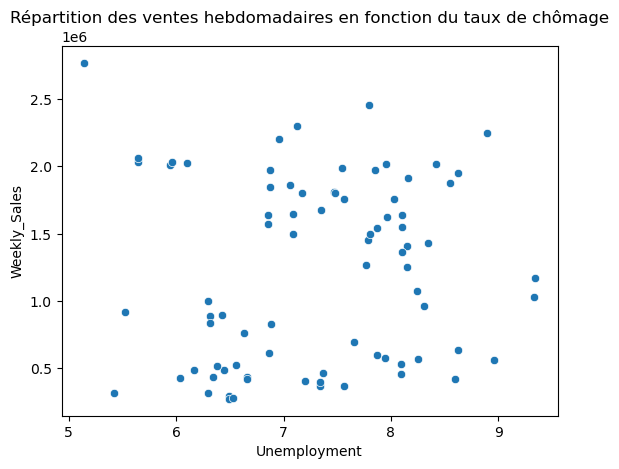

In [56]:
sns.scatterplot(data=dataset_clean, x="Unemployment", y="Weekly_Sales")
plt.title("Répartition des ventes hebdomadaires en fonction du taux de chômage")
plt.show()

Il ne semble pas y avoir de corrélation entre le taux de chômage et les ventes hebdomadaires.

### Matrice de corrélation

<Axes: >

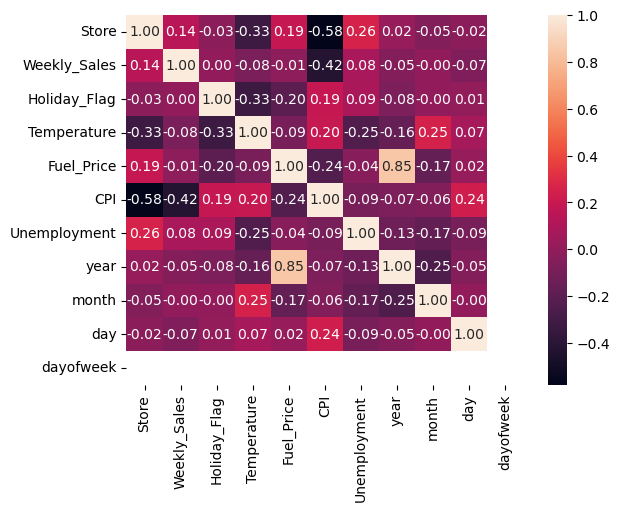

In [57]:
mat_corr = dataset_clean.corr()
sns.heatmap(mat_corr, annot=True, fmt=".2f")

D'après cette heatmap, nous ne pouvons pas déterminer de corrélation évidente entre une variable et les ventes hebdomadaires.

## Preprocessing

On crée les ensembles X (variables explicatives) et y (variable cible)

In [58]:
y = dataset_clean["Weekly_Sales"]
X = dataset_clean.drop("Weekly_Sales", axis=1)

print("y :")
print(y.head())
print()
print("X :")
print(X.head())

y :
0    1572117.54
1    1807545.43
2    1644470.66
3     695396.19
4    2203523.20
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           0.0    15.338889       3.045  214.777523         6.858   
1   13.0           0.0     5.766667       3.435  128.616064         7.470   
2    6.0           0.0    26.050000       2.759  212.412888         7.092   
3   15.0           0.0    21.000000       4.069  134.855161         7.658   
4   20.0           0.0     4.405556       3.617  213.023622         6.961   

   year  month  day  dayofweek  
0  2011      2   18          4  
1  2011      3   25          4  
2  2010      5   28          4  
3  2011      6    3          4  
4  2012      2    3          4  


On supprime la colonne dayofweek de X, puisqu'elle ne contient que des 4.

In [59]:
X = X.drop(["dayofweek"], axis=1)
X.head()

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,6.0,0.0,15.338889,3.045,214.777523,6.858,2011,2,18
1,13.0,0.0,5.766667,3.435,128.616064,7.470,2011,3,25
2,6.0,0.0,26.050000,2.759,212.412888,7.092,2010,5,28
3,15.0,0.0,21.000000,4.069,134.855161,7.658,2011,6,3
4,20.0,0.0,4.405556,3.617,213.023622,6.961,2012,2,3


On crée deux listes : une liste avec les variables numériques et une liste avec les variables catégorielles.

In [60]:
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "year", "month", "day"]
categorical_features = ["Store", "Holiday_Flag"]

On divise X et y en train/test set.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

On crée nos pipelines et notre preprocessor.

In [62]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [63]:
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) 

print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
    Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
3    15.0           0.0    21.000000       4.069  134.855161         7.658   
22    4.0           0.0    27.694444       3.570  129.066300         5.946   
7     7.0           0.0     2.561111       3.767  192.826069         8.595   
26    1.0           1.0     3.616667       2.548  211.242170         8.106   
42   18.0           0.0    23.150000       2.792  132.614193         9.342   

    year  month  day  
3   2011      6    3  
22  2011      6   24  
7   2011      5   13  
26  2010      2   12  
42  2010      8    6  
...Done.
[[ 0.58589224  1.56199819 -1.05536176  0.30814094  0.18751465 -0.1099386
  -1.45366334  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          1.          0.        ]
 [ 1.28430802  0.570

# Partie 2 : Modèle de base (Regression linéaire)

In [64]:
model = LinearRegression()
print("Train model...")
model.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


In [65]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("R2 score on training set :", r2_score(y_train, y_train_pred))
print("R2 score on test set :", r2_score(y_test, y_test_pred))

R2 score on training set : 0.983619043388679
R2 score on test set : 0.9584738281103967


Le modèle est très performant ! Récupérons les coefficients de la regression.

In [66]:
# On récupère le nom des colonnes correspondantes aux coefficients de la regression :
column_names = []
for name, transformer, features_list in preprocessor.transformers_:
    if name == 'num' :
        features = features_list
    else :
        features = transformer.get_feature_names_out()
    column_names.extend(features)

# Création du dataframe avec les coefficients par feature :
coefs = pd.DataFrame(index = column_names, data=model.coef_.transpose(), columns=["coefs"])
coefs

,coefs
Temperature,-5.761883e+04
Fuel_Price,-8.370849e+04
CPI,1.635968e+06
Unemployment,-9.357707e+04
year,-9.700821e+04
month,3.888976e+04
day,-4.673073e+04
Store_1.0,-1.041635e+06
Store_2.0,-8.633680e+05
Store_3.0,-2.499275e+06


On prend la valeur absolue des coefficients, puis on trie ce dataframe par ordre décroissant de coefficients.

In [67]:
feature_importance = abs(coefs).sort_values(by = "coefs", ascending=False)
feature_importance

,coefs
Store_4.0,2.991051e+06
Store_10.0,2.923058e+06
Store_13.0,2.882275e+06
Store_5.0,2.538706e+06
Store_3.0,2.499275e+06
Store_9.0,2.494484e+06
Store_19.0,2.146531e+06
Store_8.0,2.040696e+06
Store_18.0,1.816023e+06
CPI,1.635968e+06


On transforme les index en une colonne (comme ça, c'est plus simple pour afficher les coefficients graphiquement)

In [68]:
feature_importance = feature_importance.reset_index()
feature_importance

,index,coefs
0,Store_4.0,2.991051e+06
1,Store_10.0,2.923058e+06
2,Store_13.0,2.882275e+06
3,Store_5.0,2.538706e+06
4,Store_3.0,2.499275e+06
5,Store_9.0,2.494484e+06
6,Store_19.0,2.146531e+06
7,Store_8.0,2.040696e+06
8,Store_18.0,1.816023e+06
9,CPI,1.635968e+06


Visualisons cela sur un graphique.

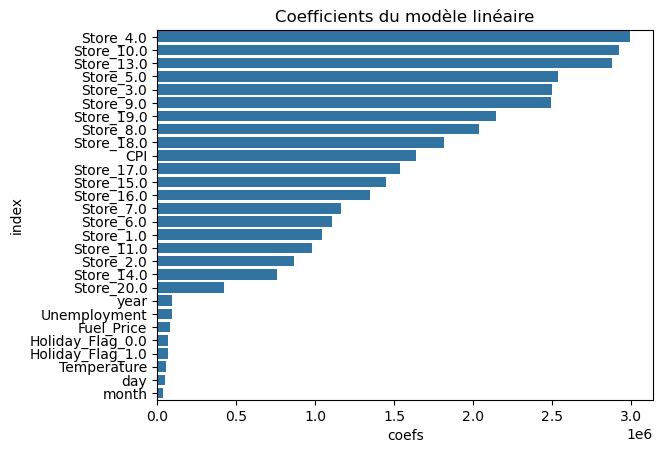

In [69]:
sns.barplot(data=feature_importance, x="coefs", y="index", orient="h")
plt.title("Coefficients du modèle linéaire")
plt.show()

On peut voir que les variables Store et CPI sont les variables qui ont le plus de poids dans cette regression linéaire. \
Il serait intéressant d'avoir plus d'informations sur les magasins en eux-mêmes.

# Partie 3 : Combattre le surapprentissage

In [70]:
ridge1 = Ridge()
ridge1.fit(X_train, y_train)

print("R2 score on training set :", ridge1.score(X_train, y_train))
print("R2 score on test set :", ridge1.score(X_test, y_test))

R2 score on training set : 0.9289247489578696
R2 score on test set : 0.9117022677325707


In [71]:
lasso1 = Lasso()
lasso1.fit(X_train, y_train)
print("R2 score on training set :", lasso1.score(X_train, y_train))
print("R2 score on test set :", lasso1.score(X_test, y_test))

R2 score on training set : 0.9820813724480625
R2 score on test set : 0.9739367179089298


d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+11, tolerance: 2.905e+09
  model = cd_fast.enet_coordinate_descent(


# Question bonus : Affinage de la force de régularisation

In [72]:
ridge2 = Ridge()

params = {"alpha" : [0.001,0.01,0.1,1,10,100]}

gridsearch_ridge = GridSearchCV(ridge2, param_grid=params, cv=10)
gridsearch_ridge.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best validation R2 score : ", gridsearch_ridge.best_score_)

print("R2 score on training set :", gridsearch_ridge.score(X_train, y_train))
print("R2 score on test set :", gridsearch_ridge.score(X_test, y_test))

Best hyperparameters :  {'alpha': 0.001}
Best validation R2 score :  0.9307092575577203
R2 score on training set : 0.9830831944015869
R2 score on test set : 0.9693478362519256


In [73]:
lasso2 = Lasso()

params = {"alpha" : [0.001,0.01,0.1,1,10,100]}

gridsearch_lasso = GridSearchCV(lasso2, param_grid=params, cv=10)
gridsearch_lasso.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch_lasso.best_params_)
print("Best validation R2 score : ", gridsearch_lasso.best_score_)

print("R2 score on training set :", gridsearch_lasso.score(X_train, y_train))
print("R2 score on test set :", gridsearch_lasso.score(X_test, y_test))

d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e+11, tolerance: 2.426e+09
  model = cd_fast.enet_coordinate_descent(
d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+11, tolerance: 2.666e+09
  model = cd_fast.enet_coordinate_descent(
d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e+11, tolerance: 2.3

Best hyperparameters :  {'alpha': 0.001}
Best validation R2 score :  0.929341954775472
R2 score on training set : 0.9820871079016708
R2 score on test set : 0.9739171518148821


d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+11, tolerance: 2.378e+09
  model = cd_fast.enet_coordinate_descent(
d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+11, tolerance: 2.568e+09
  model = cd_fast.enet_coordinate_descent(
d:\Programmes\Anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e+11, tolerance: 2.7